In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist

In [75]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info = True,
    as_supervised= True
)

### 클래스 개수 확인 : 5개

In [76]:
num_classes = metadata.features['label'].num_classes
print(num_classes)

5


### 클래스의 종류 확인

In [77]:
get_label_name = metadata.features['label'].int2str
[get_label_name(n) for n in range(5)]

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

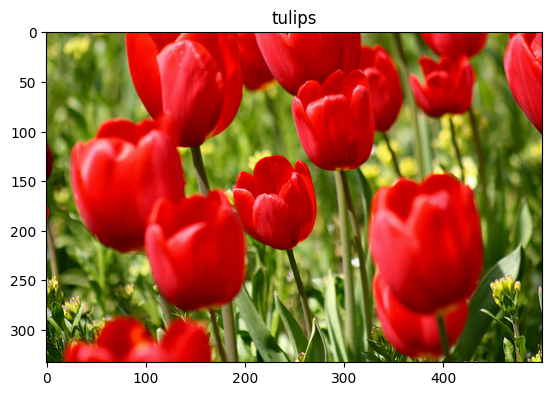

In [78]:
get_label_name = metadata.features['label'].int2str

image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

### 크기와 비율 조절

In [79]:
IMG_SIZE = 180

resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE),
    layers.experimental.preprocessing.Rescaling(1./255)
                                    # Resclae(1./127.5, offset=-1) 과 같은 설정
])

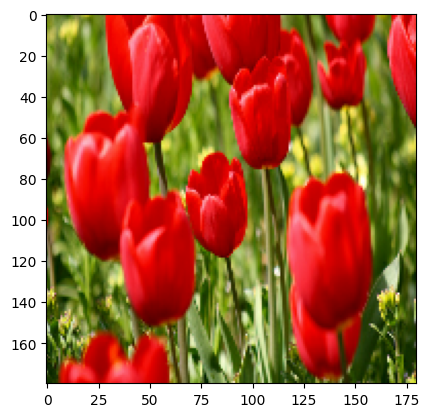

In [80]:
result = resize_and_rescale(image)
_ = plt.imshow(result)

### 변경된 픽셀 범위 확인



In [81]:
print('Min and Max pixel values :', image.numpy().min(), result.numpy().max())

Min and Max pixel values : 0 1.0


### 데이터 회전과 관련된 증강

In [82]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
                                    # 이미지 데이터를 무작위로 수평 및 수직으로 뒤집어 증강
    layers.experimental.preprocessing.RandomRotation(0.2)
                                    # 이미지를 무작위로 회전하는 변환(Transform)을 수행, 여기서 회전 각도의 범위는 0.2
])

### tf.expand_dims의 역할
- 텐서의 차원(dimension)을 확장(증가)하는 기능, 주어진 텐서의 특정 위치에 새로운 차원을 추가

In [83]:
image.shape
# 3차원

TensorShape([333, 500, 3])

In [84]:
# 이미지에 batch 차원 더하기
image = tf.expand_dims(image, 0)

In [85]:
image.shape
# 4차원

TensorShape([1, 333, 500, 3])

### 증강 확인

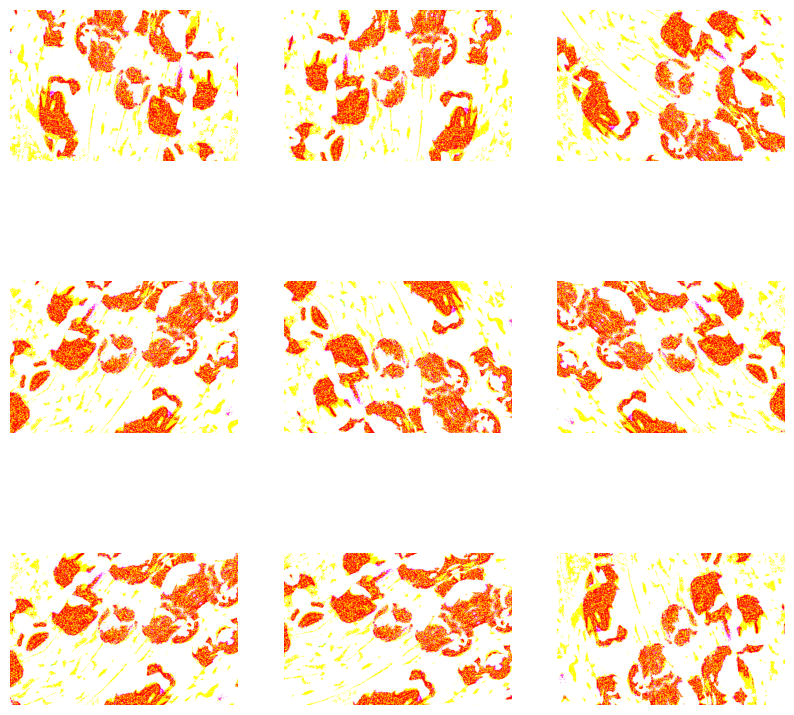

In [86]:
plt.figure(figsize=(10, 10))
for i in range(9):
    augmented_image = data_augmentation(image)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_image[0])
    plt.axis('off')

### 모델에서의 증강 구현
- 모델에서 데이터 증강을 레이어로 시키면 GPU 가속을 이용할 수 있음
- model.evaluate, model.predict에서는 실행이 안되면
- model.fit을 통해서만 증강 가능

In [87]:
model = tf.keras.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D()
])

### 다른 방식

In [88]:
aug_ds = train_ds.map(
    lambda x, y : (resize_and_rescale(x, training=True), y)
)

### 데이터 증강을 위한 전처리 구성 함수
### AUTOTUNE
  - TensorFlow에서 데이터셋을 처리할 때 자동으로 최적의 성능을 얻기 위해 사용되는 상수
  - 이는 데이터셋의 처리 과정을 자동으로 조정하여 CPU 및 GPU 자원을 최대한 활용하는 데 도움

### num_parallel_calls
  - TensorFlow에서 데이터셋의 변환(Transform) 함수를 병렬로 처리(CPU 또는 GPU의 다중 코어를 활용하여
  - 데이터셋을 효율적으로 처리 및 처리 속도 향상)하는 데 사용되는 매개변수로
  - map() 또는 interleave()와 같은 데이터셋의 변환 함수에 전달

### prefetch
  - 모델이 현재 데이터를 처리하는 동안 다음 데이터를 미리 로드하여 메모리에 유지
  - 이렇게 함으로써 데이터를 로드하는 동안 발생하는 대기 시간을 줄이고 모델의 학습 속도를 향상
  - buffer_size 매개변수를 지정하여 미리 로드할 데이터의 양을 설정
  - 여기서처럼 AUTOTUNE을 사용하면 TensorFlow가 실행 환경에 따라 최적의 버퍼 크기를 자동으로 선택

In [89]:
batch_size = 32
AUTOTUNE = tf.data.experimental.AUTOTUNE

def prepare(ds, shuffle=False, augment=False):
    # 모든 데이터에 resize_and_rescale 적용
    ds = ds.map(lambda x, y : (resize_and_rescale(x), y),
                num_parallel_calls=AUTOTUNE)
    # shuffle이 기본적으로 False로 설정되어 있어 True일 때 실행
    if shuffle:
        ds = ds.shuffle(1000)

    ds = ds.batch(batch_size)
    # augment가 기본적으로 False로 설정되어 있어 True일 때 실행
    if augment:
        ds = ds.map(lambda x, y : (data_augmentation(x, training=True), y),
                    num_parallel_calls=AUTOTUNE)

    return ds.prefetch(buffer_size=AUTOTUNE)


### 데이터 구성

In [90]:
train_ds = prepare(train_ds, shuffle=True, augment=True)
val_ds = prepare(val_ds)
test_ds = prepare(test_ds)

### 모델 구성

In [91]:
model = tf.keras.Sequential([
    layers.Conv2D(16, 3, padding='same', activation = 'relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation = 'relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation = 'relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation = 'relu'),
    layers.Dense(num_classes)
])

### compile

In [92]:
model.compile(optimizer='adam',
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics='accuracy')

### 학습

In [93]:
epochs = 5

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/5
92/92 [==============================] - 17s 143ms/step - loss: 1.2388 - accuracy: 0.4714 - val_loss: 1.0604 - val_accuracy: 0.6267
Epoch 2/5
92/92 [==============================] - 12s 120ms/step - loss: 1.0335 - accuracy: 0.5841 - val_loss: 1.0091 - val_accuracy: 0.6213
Epoch 3/5
92/92 [==============================] - 12s 119ms/step - loss: 0.9553 - accuracy: 0.6192 - val_loss: 0.9052 - val_accuracy: 0.6376
Epoch 4/5
92/92 [==============================] - 12s 120ms/step - loss: 0.8769 - accuracy: 0.6529 - val_loss: 0.8542 - val_accuracy: 0.6649
Epoch 5/5
92/92 [==============================] - 11s 105ms/step - loss: 0.8220 - accuracy: 0.6778 - val_loss: 0.8444 - val_accuracy: 0.6894


In [94]:
loss, acc = model.evaluate(test_ds)
print('Accuracy', acc)

12/12 [==============================] - 1s 76ms/step - loss: 0.8015 - accuracy: 0.6757
Accuracy 0.6757493019104004


### 람다레이어를 이용한 데이터 증강

In [95]:
def random_invert_img(x, p=0.5):
  if tf.random.uniform([]) < p:
    x = (255 - x)
  else:
    x
  return x

In [96]:
def random_invert(factor=0.5):
  return layers.Lambda(lambda x : random_invert_img(x, factor))

random_invert = random_invert()

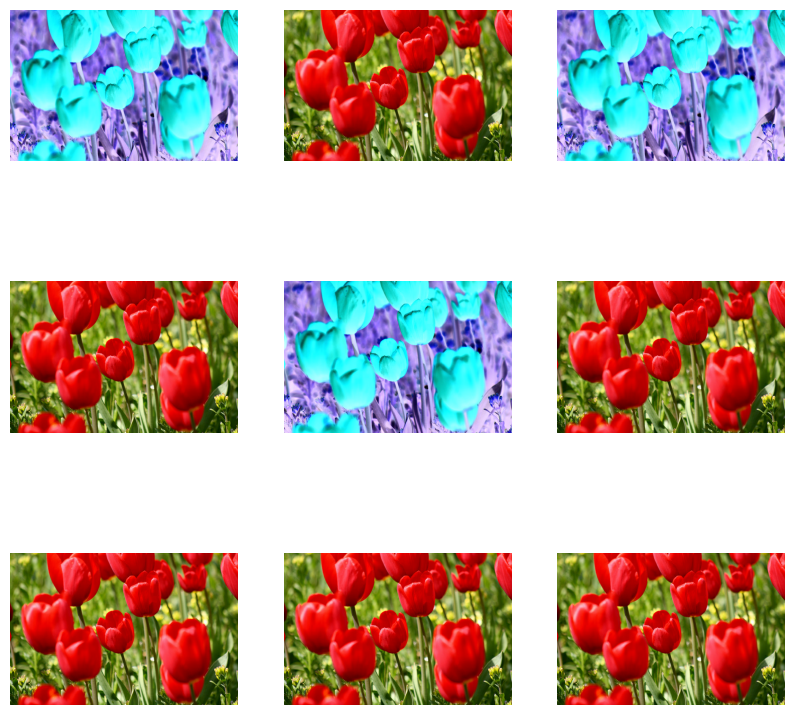

In [97]:
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = random_invert(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0].numpy().astype('uint8'))
  plt.axis('off')

### 서브클래스를 이용

In [98]:
class RandomInvert(layers.Layer):
  def __init__(self, factor = 0.5, **kwargs):
    super().__init__(**kwargs)
    self.factor = factor

  def call(self, x):
    return random_invert_img(x)

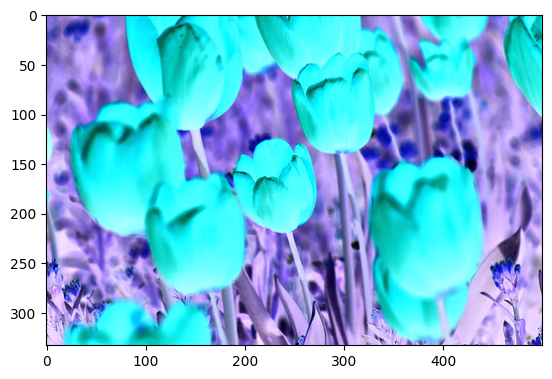

In [100]:
_ = plt.imshow(RandomInvert()(image)[0])

### 다른 방법

In [101]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info = True,
    as_supervised= True
)

- iter(train_ds): 데이터셋(train_ds)을 이터레이터(iterable)로 변환
- next(...): 이터레이터에서 다음 항목을 추출
- image, label = ...: 이터레이터에서 추출된 항목을 이미지와 레이블 변수에 할당

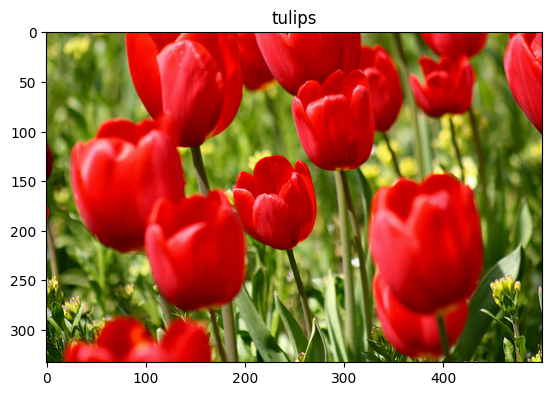

In [102]:
image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

### 비교 함수 설정

In [103]:
def visualize(original, augmented):
  fig = plt.figure()
  plt.subplot(1, 2, 1)
  plt.title('Original image')
  plt.imshow(original)

  plt.subplot(1, 2, 2)
  plt.title('Augmented image')
  plt.imshow(augmented)

### 좌우반전

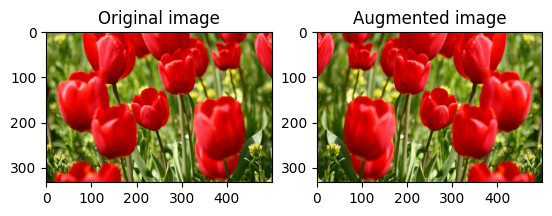

In [104]:
flipped = tf.image.flip_left_right(image)
visualize(image, flipped)

### tf.image의 gray scale

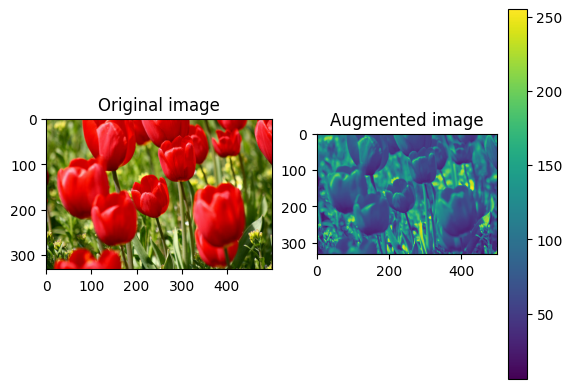

In [105]:
grayscaled = tf.image.rgb_to_grayscale(image)
visualize(image, grayscaled)
_ = plt.colorbar()

### 채도 변화

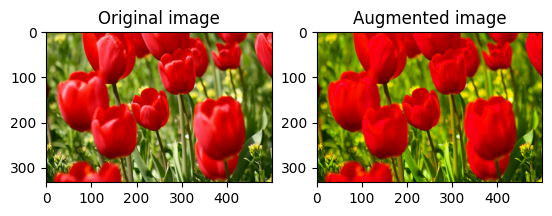

In [106]:
saturated = tf.image.adjust_saturation(image, 3)
visualize(image, saturated)

### 밝기 변화

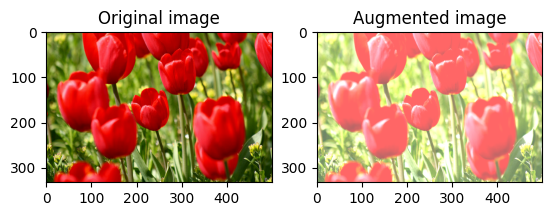

In [107]:
bright = tf.image.adjust_brightness(image, 0.4)
visualize(image, bright)

### 이미지 자르기

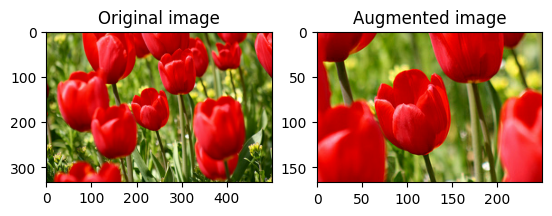

In [108]:
cropped = tf.image.central_crop(image, central_fraction=0.5)
visualize(image, cropped)

### 90도 회전

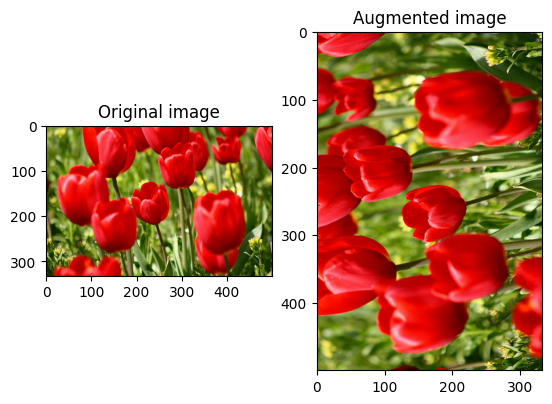

In [109]:
rotated = tf.image.rot90(image)
visualize(image, rotated)

### 증강함수 코드화

### tf.cast(image, tf.float32)
-  일반적으로 이미지 데이터를 다룰 때는 데이터의 값 범위를 [0, 255]에서 [0.0, 1.0] 또는 [-1.0, 1.0]로 정규화(normalization)하여 사용
- 이를 위해서는 먼저 이미지 데이터의 데이터 타입을 부동소수점(float)으로 변환하는 것이 필요
- tf.cast(image, tf.float32)를 사용하여 이미지 데이터를 부동소수점으로 변환

In [110]:
IMG_SIZE = 180

def resize_and_rescale(image, label):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
  image = (image/255.0)
  return image, label

### resize_with_crop_or_pad
- 이미지 잘라내기 또는 패딩: 주어진 이미지를 지정된 크기로 잘라내거나 패딩하여 크기를 조정
- IMG_SIZE + 6 크기로 수행하면 원본 이미지를 중앙에서 IMG_SIZE만큼 자르기
- 만약 이미지가 이보다 작다면 이미지 주위에 패딩이 추가

### random_brightness의 max_delta
- max_delta 매개변수는 밝기 변환에 사용되는 최대 차이값을 지정
- 이 값은 [-max_delta, max_delta] 범위에서 랜덤하게 선택되어 밝기를 조정
- 여기선 max_delta=0.5로 설정하여 이미지의 밝기를 -0.5에서 0.5 사이의 값으로 랜덤하게 조정

### clip_by_value
- 값의 클리핑: 주어진 텐서의 각 요소를 최소값(minimum)과 최대값(maximum) 사이의 값 수정
- 범위 제한: 텐서의 각 요소를 지정된 최소값과 최대값 사이의 값으로 제한
- 여기선 tf.clip_by_value(image, 0, 1)은 이미지 픽셀 값이 0 미만이거나 1을 초과하는 경우
- 해당 값을 0 또는 1로 클리핑하여 이미지의 픽셀 값을 [0, 1] 범위로 유지

In [111]:
def augment(image, label):
  image, lable = resize_and_rescale(image, label)
  image = tf.image.resize_with_crop_or_pad(image, IMG_SIZE + 6, IMG_SIZE + 6)
                  # random_crop : 데이터를 랜덤하게 자르기
  image = tf.image.random_crop(image, size=[IMG_SIZE, IMG_SIZE, 3])
  image = tf.image.random_brightness(image, max_delta = 0.5)
  image = tf.clip_by_value(image, 0, 1)
  return image, label

### 데이터 재구성

In [112]:
train_ds = (
    train_ds
    .shuffle(1000)
    .map(augment, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

In [113]:
val_ds = (
    val_ds
    .map(resize_and_rescale, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

In [114]:
test_ds = (
    test_ds
    .map(resize_and_rescale, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)